In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import jax
# jax.config.update("jax_enable_x64", True)

import jax.numpy as jnp
import jax.random as jr
from jax.tree_util import Partial

import hugegp as gp
import hugegp_cuda as hgc
import jaxkd as jk

import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
import time
from tqdm import tqdm

rng = jr.key(137)

In [76]:
r = jnp.linspace(0, 1, 40)[:,None]
pairwise_r = jnp.linalg.norm(r[:, None] - r[None, :], axis=-1)
K = gp.matern_cov(pairwise_r)
L = jnp.linalg.cholesky(K)

rng, key = jr.split(rng)
xi = jr.normal(key, shape=(len(r),))

v_true = L @ xi

i = len(r) - 7
L_trunc = jnp.linalg.cholesky(K[i:,i:])
v_trunc = v_true[i:-1]
v_last_trunc = L_trunc[-1,:-1] @ jnp.linalg.solve(L_trunc[:-1,:-1], v_trunc) + L_trunc[-1,-1] * xi[-1]

print(v_true[-1], v_last_trunc)

-0.8690978 -0.8690127


In [48]:
r = jnp.array([
    [0.0, 0.2, 0.1],
    [0.2, 0.0, 0.1],
    [0.1, 0.1, 0.0]
])

K = gp.matern_cov(r, cutoff=0.4)
L = jnp.linalg.cholesky(K)

K_fake = jnp.array([
    [1.00001, 0.7],
    [0.7, 1.00001]
])
L_fake = jnp.linalg.cholesky(K_fake)

In [80]:
rng, key = jr.split(rng)
xi = jr.normal(key, (2, 10000))
values = L[:2, :2] @ xi

In [89]:
jnp.linalg.norm(L[2,:2] @ jnp.linalg.solve(L[:2,:2], L_fake))**2 + L[2,2]**2

Array(0.9539802, dtype=float32)

In [53]:
rng, key = jr.split(rng)
fine_xi = jr.normal(key, (10000,))
mean = L[2, :2] @ jnp.linalg.solve(L[:2, :2], values)
std = L[2, 2]
fine_value = mean + std * fine_xi

In [54]:
jnp.var(mean)

Array(0.9758485, dtype=float32)

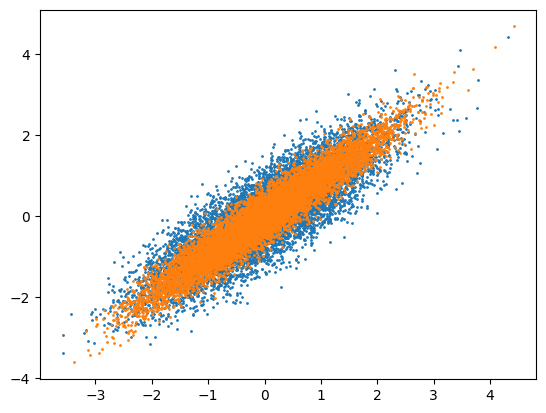

In [47]:
plt.scatter(values[0], values[1], s=1)
plt.scatter(values[1], fine_value, s=1)